In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses
from sklearn.preprocessing import MultiLabelBinarizer

# Fix the dying kernel problem (only a problem in some installations - you can remove it, if it works without it)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

C:\Users\arciom\anaconda3\envs\rs-class-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the dataset for recommenders

In [2]:
data_path = os.path.join("data", "hotel_data")

interactions_df = pd.read_csv(os.path.join(data_path, "hotel_data_interactions_df.csv"), index_col=0)

base_item_features = ['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 'n_people_bucket', 'weekend_stay']

column_values_dict = {
    'term': ['WinterVacation', 'Easter', 'OffSeason', 'HighSeason', 'LowSeason', 'MayLongWeekend', 'NewYear', 'Christmas'],
    'length_of_stay_bucket': ['[0-1]', '[2-3]', '[4-7]', '[8-inf]'],
    'rate_plan': ['Standard', 'Nonref'],
    'room_segment': ['[0-160]', '[160-260]', '[260-360]', '[360-500]', '[500-900]'],
    'n_people_bucket': ['[1-1]', '[2-2]', '[3-4]', '[5-inf]'],
    'weekend_stay': ['True', 'False']
}

interactions_df.loc[:, 'term'] = pd.Categorical(
    interactions_df['term'], categories=column_values_dict['term'])
interactions_df.loc[:, 'length_of_stay_bucket'] = pd.Categorical(
    interactions_df['length_of_stay_bucket'], categories=column_values_dict['length_of_stay_bucket'])
interactions_df.loc[:, 'rate_plan'] = pd.Categorical(
    interactions_df['rate_plan'], categories=column_values_dict['rate_plan'])
interactions_df.loc[:, 'room_segment'] = pd.Categorical(
    interactions_df['room_segment'], categories=column_values_dict['room_segment'])
interactions_df.loc[:, 'n_people_bucket'] = pd.Categorical(
    interactions_df['n_people_bucket'], categories=column_values_dict['n_people_bucket'])
interactions_df.loc[:, 'weekend_stay'] = interactions_df['weekend_stay'].astype('str')
interactions_df.loc[:, 'weekend_stay'] = pd.Categorical(
    interactions_df['weekend_stay'], categories=column_values_dict['weekend_stay'])

display(HTML(interactions_df.head(15).to_html()))

,user_id,item_id,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,0,WinterVacation,[2-3],Standard,[260-360],[5-inf],True
1,2,1,WinterVacation,[2-3],Standard,[160-260],[3-4],True
2,3,2,WinterVacation,[2-3],Standard,[160-260],[2-2],False
3,4,3,WinterVacation,[4-7],Standard,[160-260],[3-4],True
4,5,4,WinterVacation,[4-7],Standard,[0-160],[2-2],True
5,6,5,Easter,[4-7],Standard,[260-360],[5-inf],True
6,7,6,OffSeason,[2-3],Standard,[260-360],[5-inf],True
7,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True
8,9,8,HighSeason,[2-3],Standard,[0-160],[1-1],True
9,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True


# (Optional) Prepare numerical user features

The method below is left here for convenience if you want to experiment with content-based user features as an input for your neural network.

In [3]:
def n_to_p(l):
    n = sum(l)
    return [x / n for x in l] if n > 0 else l

def calculate_p(x, values):
    counts = [0]*len(values)
    #print(counts)
    ####
    #newlist = [elem for elem in x if np.isnan(elem) == False]
    #x = newlist
    #print(x)
    #print(values)
    for v in x:
#         print(values.index(v))
        if v in values:
            counts[values.index(v)] += 1
#         counts[values.index(v)] += 1

    return n_to_p(counts)

def prepare_users_df(interactions_df):

    users_df = interactions_df.loc[:, ["user_id"]]
    users_df = users_df.groupby("user_id").first().reset_index(drop=False)
    
    user_features = []

    for column in base_item_features:

        column_values = column_values_dict[column]
        df = interactions_df.loc[:, ['user_id', column]]
        df = df.groupby('user_id').aggregate(lambda x: list(x)).reset_index(drop=False)

        def calc_p(x):
            return calculate_p(x, column_values)

        df.loc[:, column] = df[column].apply(lambda x: calc_p(x))

        p_columns = []
        for i in range(len(column_values)):
            p_columns.append("user_" + column + "_" + column_values[i])
            df.loc[:, p_columns[i]] = df[column].apply(lambda x: x[i])
            user_features.append(p_columns[i])

        users_df = pd.merge(users_df, df.loc[:, ['user_id'] + p_columns], on=["user_id"])
    
    return users_df, user_features
    

users_df, user_features = prepare_users_df(interactions_df)

print(user_features)

display(HTML(users_df.loc[users_df['user_id'].isin([706, 1736, 7779, 96, 1, 50, 115])].head(15).to_html()))

['user_term_WinterVacation', 'user_term_Easter', 'user_term_OffSeason', 'user_term_HighSeason', 'user_term_LowSeason', 'user_term_MayLongWeekend', 'user_term_NewYear', 'user_term_Christmas', 'user_length_of_stay_bucket_[0-1]', 'user_length_of_stay_bucket_[2-3]', 'user_length_of_stay_bucket_[4-7]', 'user_length_of_stay_bucket_[8-inf]', 'user_rate_plan_Standard', 'user_rate_plan_Nonref', 'user_room_segment_[0-160]', 'user_room_segment_[160-260]', 'user_room_segment_[260-360]', 'user_room_segment_[360-500]', 'user_room_segment_[500-900]', 'user_n_people_bucket_[1-1]', 'user_n_people_bucket_[2-2]', 'user_n_people_bucket_[3-4]', 'user_n_people_bucket_[5-inf]', 'user_weekend_stay_True', 'user_weekend_stay_False']


,user_id,user_term_WinterVacation,user_term_Easter,user_term_OffSeason,user_term_HighSeason,user_term_LowSeason,user_term_MayLongWeekend,user_term_NewYear,user_term_Christmas,user_length_of_stay_bucket_[0-1],user_length_of_stay_bucket_[2-3],user_length_of_stay_bucket_[4-7],user_length_of_stay_bucket_[8-inf],user_rate_plan_Standard,user_rate_plan_Nonref,user_room_segment_[0-160],user_room_segment_[160-260],user_room_segment_[260-360],user_room_segment_[360-500],user_room_segment_[500-900],user_n_people_bucket_[1-1],user_n_people_bucket_[2-2],user_n_people_bucket_[3-4],user_n_people_bucket_[5-inf],user_weekend_stay_True,user_weekend_stay_False
0,1,0.090909,0.0,0.681818,0.090909,0.136364,0.000000,0.000000,0.0,0.000000,0.590909,0.409091,0.000000,0.500000,0.500000,0.000000,0.863636,0.136364,0.0,0.0,0.000000,0.727273,0.181818,0.090909,0.863636,0.136364
40,50,0.043478,0.0,0.434783,0.304348,0.217391,0.000000,0.000000,0.0,0.000000,0.913043,0.086957,0.000000,0.260870,0.739130,0.000000,0.565217,0.434783,0.0,0.0,0.000000,0.173913,0.521739,0.304348,0.782609,0.217391
84,96,0.090909,0.0,0.681818,0.136364,0.045455,0.045455,0.000000,0.0,0.272727,0.636364,0.045455,0.045455,0.272727,0.727273,0.045455,0.863636,0.090909,0.0,0.0,0.045455,0.272727,0.590909,0.090909,0.772727,0.227273
102,115,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.500000,0.500000,0.000000,1.000000,0.000000,0.000000,0.500000,0.500000,0.0,0.0,0.500000,0.000000,0.000000,0.500000,0.000000,1.000000
371,706,0.095238,0.0,0.511905,0.190476,0.142857,0.047619,0.011905,0.0,0.297619,0.380952,0.238095,0.083333,0.976190,0.023810,0.035714,0.857143,0.107143,0.0,0.0,0.120482,0.156627,0.590361,0.132530,0.726190,0.273810
1383,1736,0.034483,0.0,0.482759,0.206897,0.275862,0.000000,0.000000,0.0,0.241379,0.551724,0.206897,0.000000,0.172414,0.827586,0.000000,0.931034,0.068966,0.0,0.0,0.379310,0.413793,0.206897,0.000000,0.482759,0.517241
7301,7779,0.000000,0.0,0.500000,0.000000,0.500000,0.000000,0.000000,0.0,0.000000,0.250000,0.500000,0.250000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.750000,0.250000,1.000000,0.000000


# (Optional) Prepare numerical item features

The method below is left here for convenience if you want to experiment with content-based item features as an input for your neural network.

In [4]:
def map_items_to_onehot(df):
    one_hot = pd.get_dummies(df.loc[:, base_item_features])
    df = df.drop(base_item_features, axis = 1)
    df = df.join(one_hot)
    
    return df, list(one_hot.columns)

def prepare_items_df(interactions_df):
    items_df = interactions_df.loc[:, ["item_id"] + base_item_features].drop_duplicates()
    
    items_df, item_features = map_items_to_onehot(items_df)
    
    return items_df, item_features


items_df, item_features = prepare_items_df(interactions_df)

print(item_features)

display(HTML(items_df.loc[items_df['item_id'].isin([0, 1, 2, 3, 4, 5, 6])].head(15).to_html()))

['term_WinterVacation', 'term_Easter', 'term_OffSeason', 'term_HighSeason', 'term_LowSeason', 'term_MayLongWeekend', 'term_NewYear', 'term_Christmas', 'length_of_stay_bucket_[0-1]', 'length_of_stay_bucket_[2-3]', 'length_of_stay_bucket_[4-7]', 'length_of_stay_bucket_[8-inf]', 'rate_plan_Standard', 'rate_plan_Nonref', 'room_segment_[0-160]', 'room_segment_[160-260]', 'room_segment_[260-360]', 'room_segment_[360-500]', 'room_segment_[500-900]', 'n_people_bucket_[1-1]', 'n_people_bucket_[2-2]', 'n_people_bucket_[3-4]', 'n_people_bucket_[5-inf]', 'weekend_stay_True', 'weekend_stay_False']


,item_id,term_WinterVacation,term_Easter,term_OffSeason,term_HighSeason,term_LowSeason,term_MayLongWeekend,term_NewYear,term_Christmas,length_of_stay_bucket_[0-1],length_of_stay_bucket_[2-3],length_of_stay_bucket_[4-7],length_of_stay_bucket_[8-inf],rate_plan_Standard,rate_plan_Nonref,room_segment_[0-160],room_segment_[160-260],room_segment_[260-360],room_segment_[360-500],room_segment_[500-900],n_people_bucket_[1-1],n_people_bucket_[2-2],n_people_bucket_[3-4],n_people_bucket_[5-inf],weekend_stay_True,weekend_stay_False
0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0
1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
2,2,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,3,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0
4,4,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0
5,5,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0
6,6,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0


# Neural network recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Code a recommender based on a neural network model. You are free to choose any network architecture you find appropriate. The network can use the interaction vectors for users and items, embeddings of users and items, as well as user and item features (you can use the features you developed in the first project).

Remember to keep control over randomness - in the init method add the seed as a parameter and initialize the random seed generator with that seed (both for numpy and pytorch):

```python
self.seed = seed
self.rng = np.random.RandomState(seed=seed)
```
in the network model:
```python
self.seed = torch.manual_seed(seed)
```

You are encouraged to experiment with:
  - the number of layers in the network, the number of neurons and different activation functions,
  - different optimizers and their parameters,
  - batch size and the number of epochs,
  - embedding layers,
  - content-based features of both users and items.

In [6]:
from recommenders.recommender import Recommender
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.autograd import Variable


class NNRecommender(Recommender):
    """
    Linear recommender class based on user and item features.
    """
    
    def __init__(self, seed=6789, n_neg_per_pos=5):
        """
        Initialize recommender params and variables.
        """
        self.model = None
        self.n_neg_per_pos = n_neg_per_pos
        
        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.users_df = None
        self.user_features = None
        
        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)
        ##
        torch.manual_seed(seed)
        ##
        
        # You can add more arguments if needed
        # <<<Write your code here>>>
    
    def fit(self, interactions_df, users_df, items_df):
        """
        Training of the recommender.
        
        :param pd.DataFrame interactions_df: DataFrame with recorded interactions between users and items 
            defined by user_id, item_id and features of the interaction.
        :param pd.DataFrame users_df: DataFrame with users and their features defined by user_id and the user feature columns.
        :param pd.DataFrame items_df: DataFrame with items and their features defined by item_id and the item feature columns.
        """
        
        interactions_df = interactions_df.copy()
        
        # Prepare users_df and items_df 
        # (optional - use only if you want to train a hybrid model with content-based features)
        
        users_df, user_features = prepare_users_df(interactions_df)
        
        self.users_df = users_df
        self.user_features = user_features
        
        items_df, item_features = prepare_items_df(interactions_df)
        items_df = items_df.loc[:, ['item_id'] + item_features]
        
        # Generate negative interactions
        
        # <<<Write your code here>>>
        
        negative_interactions = []
        
        
        ##
        min_item_id = interactions_df['item_id'].min()
        max_item_id = interactions_df['item_id'].max()
        
        dict_interactions_df = interactions_df.to_dict('records')
        for row in dict_interactions_df:
            #filter on user_id
            filtered_df_on_user_id = interactions_df[interactions_df.user_id.isin([row['user_id']])]
            
            #find five negative interactions
            nr_of_neg_interactions = 0
            while True:
                if nr_of_neg_interactions == 5:
                    break
                
                rand_item_id = np.random.randint(min_item_id, max_item_id)
                if not (filtered_df_on_user_id['item_id'].values == [rand_item_id]).any():
                    negative_interactions.append((row['user_id'], rand_item_id, 0))
                    nr_of_neg_interactions += 1
        
        #generator of negative interactions is taken about 11-18 seconds
        ##
        
        
        
        interactions_df = pd.concat(
            [interactions_df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])
        
        # Merge user and item features
        # (optional - use only if you want to train a hybrid model with content-based features)
        
        interactions_df = pd.merge(interactions_df, users_df, on=['user_id'])
        interactions_df = pd.merge(interactions_df, items_df, on=['item_id'])
        
        #change NAN with fillna
        interactions_df['interacted'] = interactions_df['interacted'].fillna(0).astype(float)
        #

        # Initialize the neural network model
        
        # <<<Write your code here>>>
        ##
        self.model = NetworkModel(len(user_features) + len(item_features), self.seed)
        self.model.train()
        criterion = nn.MSELoss()#nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)
        ##
        
        # Train the model using an optimizer
        
        # <<<Write your code here>>>
        
        
#         ##matrix factorization
#         users_id_list = interactions_df['user_id'].tolist()
#         items_id_list = interactions_df['item_id'].tolist()
#         interacted_list = interactions_df['interacted'].tolist()
        
        
#         self.model = MatrixFactorization(self.seed, len(users_id_list), len(items_id_list), n_factors=8)
#         loss_fn = nn.MSELoss() 
#         optimizer = torch.optim.SparseAdam(self.model.parameters(), lr=0.01, eps=1e-08)#torch.optim.Adam(self.model.parameters(), lr=0.01)#torch.optim.SGD(self.model.parameters(), lr=1e-6)
        
        
        
#         data = []
        
        
#         for index in range(len(users_id_list)):
#             data.append((torch.tensor(users_id_list[index]), torch.tensor(items_id_list[index]), torch.tensor(interacted_list[index])))
        
#         n_epochs = 100
#         for epoch in range(n_epochs):
#             optimizer.zero_grad()
            
#             for index in range(len(data)):
#                 prediction = self.model(Variable(data[index][0]), Variable(data[index][1]))
#                 loss = loss_fn(prediction, Variable(data[index][2]))
                
#                 # backpropagate
#                 loss.backward()

#                 # update weights
#                 optimizer.step()
                
#         ##
        
        
        ##embedding
        
#         list_of_users_ids = sorted(interactions_df['user_id'].unique())
#         user_ids = []
        
#         for index in range(len(list_of_users_ids)):
#             user_ids.append(torch.tensor(list_of_users_ids[index]))
        
# #         user_ids = [torch.tensor(0), torch.tensor(1), torch.tensor(2)]
#         list_of_items_ids = sorted(interactions_df['item_id'].unique())
#         items = []
        
#         for index in range(len(list_of_items_ids)):
#             item_tensor = torch.rand(8)
#             items.append(item_tensor)
# #         items = [torch.tensor([0.6, 0.4, -0.2]), torch.tensor([-0.7, 0.8, -0.7]), torch.tensor([0.8, -0.75, 0.9])]
# #         responses = [1, 0, 0, 0, 1, 0, 0, 0, 1]
#         data = [(user_ids[user_id], items[item_id]) for user_id in range(len(list_of_users_ids)) for item_id in range(len(list_of_items_ids))]

#         self.model = EmbeddingNetworkModel(seed=6789, num_users=len(list_of_users_ids)*2, num_items=len(list_of_items_ids))

#         optimizer = optim.SGD(self.model.parameters(), lr=0.1)

#         losses = []
#         n_epochs = 100
#         for epoch in range(n_epochs):

#             optimizer.zero_grad()
    
#             for i in range(len(data)):
#                 user_id = data[i][0]
#                 item_repr = data[i][1]
# #                 print(user_id)
# #                 print(item_repr)
        
#                 y = self.model((user_id, item_repr))
# #                 if i == 0:
# #                     loss = torch.pow(y - responses[i], 2)
# #                 else:
# #                     loss += torch.pow(y - responses[i], 2)
            
# #             for param in embedding_nn.parameters():
# #                 loss += 1 / 5 * torch.norm(param)
    
#         loss.backward()
# #         losses.append(loss.item())
#         optimizer.step()
#         ##
        
        
        ##
        
        x = interactions_df.loc[:, user_features + item_features]#.values
        
        
#         ##
        x_data_tensor = torch.zeros((x.shape[1], x.shape[0]))
        columns_name_in_x = x.columns.tolist()
        for column_name in columns_name_in_x:
            column_data_tensor = torch.tensor([x[column_name].tolist()])
            x_data_tensor = torch.cat((x_data_tensor, column_data_tensor), dim=0)
                
        x_data_tensor = x_data_tensor[x.shape[1]:, :]
        
        x_data_tensor = torch.transpose(x_data_tensor, 0, 1)

        y = interactions_df['interacted'].values
    
        y_data_tensor = torch.tensor([y.tolist()])
        y_data_tensor = y_data_tensor.reshape([y_data_tensor.shape[1], y_data_tensor.shape[0]])
        
#         X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
#         X_train = torch.FloatTensor(X_train)
#         X_test = torch.FloatTensor(X_test)
#         y_train = torch.FloatTensor(y_train)
#         y_test = torch.FloatTensor(y_test)

        
        
        epochs = 1000
#         loss_arr = []
        
        for i in range(epochs):
            y_hat = (self.model.forward(x_data_tensor))
#             y_hat = (self.model.forward(X_train)).squeeze()
#             display(y_hat.shape)
#             display(y_hat)
            loss = criterion(y_hat, y_data_tensor)
#             loss = criterion(y_hat, y_train)
#             loss_arr.append(loss)
            
#             if i % 10 == 0:
#                 print(f'Epoch: {i} Loss: {loss}')
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #
    
    def recommend(self, users_df, items_df, n_recommendations=1):
        """
        Serving of recommendations. Scores items in items_df for each user in users_df and returns 
        top n_recommendations for each user.
        
        :param pd.DataFrame users_df: DataFrame with users and their features for which recommendations should be generated.
        :param pd.DataFrame items_df: DataFrame with items and their features which should be scored.
        :param int n_recommendations: Number of recommendations to be returned for each user.
        :return: DataFrame with user_id, item_id and score as columns returning n_recommendations top recommendations 
            for each user.
        :rtype: pd.DataFrame
        """
        
        # Clean previous recommendations (iloc could be used alternatively)
        self.recommender_df = self.recommender_df[:0]
        
        # Prepare users_df and items_df
        # (optional - use only if you want to train a hybrid model with content-based features)
        
        users_df = users_df.loc[:, 'user_id']
        users_df = pd.merge(users_df, self.users_df, on=['user_id'], how='left').fillna(0)
        
        items_df, item_features = prepare_items_df(items_df)
#         items_df = items_df.loc[:, ['item_id'] + item_features]

        
        ##tensor from items data
        items_data_tensor = torch.zeros((items_df.shape[1] - 1, items_df.shape[0]))
        columns_name_in_items_df = items_df.columns.tolist()
        for column_name in columns_name_in_items_df:
            if column_name != 'item_id':
                column_data_tensor = torch.tensor([items_df[column_name].tolist()])
                items_data_tensor = torch.cat((items_data_tensor, column_data_tensor), dim=0)
                
        items_data_tensor = items_data_tensor[25:, :]
        
        items_data_tensor = torch.transpose(items_data_tensor, 0, 1)

        
        # Score the items
    
        recommendations = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        
        for ix, user in users_df.iterrows():
            
            # Calculate the score for the user and every item in items_df
            # <<<Write your code here>>>
            ##
            only_one_user_df = users_df.loc[users_df['user_id'].isin([user['user_id']])]
            
            ##tensor from users data
            users_data_tensor = torch.zeros((only_one_user_df.shape[1] - 1, only_one_user_df.shape[0]))
            columns_name_in_users_df = only_one_user_df.columns.tolist()
            for column_name in columns_name_in_users_df:
                if column_name != 'user_id':
                    column_data_tensor = torch.tensor([only_one_user_df[column_name].tolist()])
                    users_data_tensor = torch.cat((users_data_tensor, column_data_tensor), dim=0)
                
            users_data_tensor = users_data_tensor[25:, :]
        
            users_data_tensor = torch.transpose(users_data_tensor, 0, 1)
            
            ##
            
            
            
            
            ##
        
            ##concatenate users tensor and items tensor to scores tensor
            tensor_for_scores = torch.zeros((1, users_data_tensor.shape[1] + items_data_tensor.shape[1]))

            for index_item in range(items_data_tensor.shape[0]):
                for index_user in range(users_data_tensor.shape[0]):
                    tensor_cross_join = torch.cat((users_data_tensor[index_user].reshape([1, users_data_tensor.shape[1]]), items_data_tensor[index_item].reshape([1, items_data_tensor.shape[1]])), dim=1)
                    tensor_for_scores = torch.cat((tensor_for_scores, tensor_cross_join), dim=0)
            
            tensor_for_scores = tensor_for_scores[1:, :]
            
            
            scores = []
            
#             data_for_scores = torch.tensor(list(zip([user['user_id']]*len(list_of_items_id), list_of_items_id)))#.to(self.device)
            scores = self.model(tensor_for_scores).flatten().detach().cpu().numpy()
            
            

            chosen_ids = np.argsort(-scores)[:n_recommendations]
            
            recommendations = []
            for item_id in chosen_ids:
                recommendations.append(
                    {
                        'user_id': user['user_id'],
                        'item_id': item_id,
                        'score': scores[item_id]
                    }
                )
            
            user_recommendations = pd.DataFrame(recommendations)

            self.recommender_df = pd.concat([self.recommender_df, user_recommendations])

        return self.recommender_df
    
    
class NetworkModel(nn.Module):
    """
    Linear regression recommender class based on user and item features.
    """
    def __init__(self, in_feat_for_layer1, seed):
        super().__init__()
        self.seed = torch.manual_seed(seed)
        self.layer1 = nn.Linear(in_features=50, out_features=100)#change in_feat100,60,200
#         self.layer2 = nn.Linear(in_features=200, out_features=25)#20,5,25
        self.output = nn.Linear(in_features=100, out_features=1)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
#         x = F.relu(self.layer2(x))
        x = self.output(x)
        return x


class EmbeddingNetworkModel(nn.Module):
    def __init__(self, seed, num_users, num_items):
        super().__init__()

        self.seed = torch.manual_seed(seed)

        self.embedding = nn.Embedding(num_users, 8)

    def forward(self, x):
        user_id = x[0]
        item_repr = x[1]
        y = self.embedding(user_id) * item_repr
        y = torch.sum(y)
        y = torch.sigmoid(y)

        return y
    
    
class MatrixFactorization(torch.nn.Module):
    def __init__(self, seed, n_users, n_items, n_factors=8):
        super().__init__()
    # create user embeddings
        self.seed = torch.manual_seed(seed)
        
        self.user_factors = torch.nn.Embedding(n_users, n_factors,
                                               sparse=True)
    # create item embeddings
        self.item_factors = torch.nn.Embedding(n_items, n_factors,
                                               sparse=True)

    def forward(self, user, item):
        # matrix multiplication
        return (self.user_factors(user)*self.item_factors(item)).sum(0)

    def predict(self, user, item):
        return self.forward(user, item)

# Quick test of the recommender

In [7]:
items_df = interactions_df.loc[:, ['item_id'] + base_item_features].drop_duplicates()

In [8]:
# Fit method
nn_recommender = NNRecommender()

####
#users_df = interactions_df.loc[:, ["user_id"]]
#users_df = users_df.groupby("user_id").first().reset_index(drop=False)

nn_recommender.fit(interactions_df, None, None)

In [9]:
# Recommender method

recommendations = nn_recommender.recommend(pd.DataFrame([[1], [2], [3], [150], [35000]], columns=['user_id']), items_df, 10)
# recommendations = nn_recommender.recommend(pd.DataFrame([[1], [2], [3], [150], [35000]], columns=['user_id']), interactions_df, 10)

recommendations = pd.merge(recommendations, items_df, on='item_id', how='left')
display(HTML(recommendations.to_html()))

,user_id,item_id,score,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1.0,620,0.002182,HighSeason,[0-1],Nonref,[260-360],[2-2],True
1,1.0,178,0.001937,Easter,[2-3],Standard,[260-360],[5-inf],True
2,1.0,239,0.001813,HighSeason,[8-inf],Standard,[260-360],[5-inf],True
3,1.0,336,0.001754,HighSeason,[0-1],Standard,[260-360],[5-inf],False
4,1.0,387,0.001692,LowSeason,[0-1],Nonref,[260-360],[2-2],True
5,1.0,347,0.001566,HighSeason,[0-1],Standard,[160-260],[5-inf],False
6,1.0,634,0.001555,LowSeason,[0-1],Standard,[0-160],[1-1],False
7,1.0,374,0.001461,LowSeason,[0-1],Standard,[160-260],[1-1],False
8,1.0,409,0.001451,WinterVacation,[4-7],Nonref,[260-360],[5-inf],True
9,1.0,488,0.00144,WinterVacation,[0-1],Nonref,[260-360],[5-inf],True


# Tuning method

In [46]:
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

seed = 6789

In [47]:
from hyperopt import hp, fmin, tpe, Trials
import traceback

def tune_recommender(recommender_class, interactions_df, items_df, 
                     param_space, max_evals=1, show_progressbar=True, seed=6789):
    # Split into train_validation and test sets

    shuffle = np.arange(len(interactions_df))
    rng = np.random.RandomState(seed=seed)
    rng.shuffle(shuffle)
    shuffle = list(shuffle)

    train_test_split = 0.8
    split_index = int(len(interactions_df) * train_test_split)

    train_validation = interactions_df.iloc[shuffle[:split_index]]
    test = interactions_df.iloc[shuffle[split_index:]]

    # Tune

    def loss(tuned_params):
        recommender = recommender_class(seed=seed, **tuned_params)
        hr1, hr3, hr5, hr10, ndcg1, ndcg3, ndcg5, ndcg10 = evaluate_train_test_split_implicit(
            recommender, train_validation, items_df, seed=seed)
        return -hr10

    n_tries = 1
    succeded = False
    try_id = 0
    while not succeded and try_id < n_tries:
        try:
            trials = Trials()
            best_param_set = fmin(loss, space=param_space, algo=tpe.suggest, 
                                  max_evals=max_evals, show_progressbar=show_progressbar, trials=trials, verbose=True)
            succeded = True
        except:
            traceback.print_exc()
            try_id += 1
            
    if not succeded:
        return None
        
    # Validate
    
    recommender = recommender_class(seed=seed, **best_param_set)

    results = [[recommender_class.__name__] + list(evaluate_train_test_split_implicit(
        recommender, {'train': train_validation, 'test': test}, items_df, seed=seed))]

    results = pd.DataFrame(results, 
                           columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

    display(HTML(results.to_html()))
    
    return best_param_set

## Tuning of the recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Tune your model using the code below. You only need to put the class name of your recommender and choose an appropriate parameter space.

In [48]:
param_space = {
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 10, 1)
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df,
                                  param_space, max_evals=10, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

100%|███████████████████████████████████████████| 10/10 [27:48<00:00, 166.87s/trial, best loss: -0.0016927634363097758]


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.0,0.000679,0.001018,0.001697,0.0,0.000384,0.000515,0.000734


Best parameters:
{'n_neg_per_pos': 10.0}


# Final evaluation

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Run the final evaluation of your recommender and present its results against the Amazon and Netflix recommenders' results. You just need to give the class name of your recommender and its tuned parameters below.

It's optional, but for better effect you can include here the results from all recommenders created during in this class.

In [235]:
nn_recommender = NNRecommender(n_neg_per_pos=1)  # Initialize your recommender here

# Give the name of your recommender in the line below
nn_tts_results = [['NNRecommender'] + list(evaluate_train_test_split_implicit(
    nn_recommender, interactions_df, items_df))]

nn_tts_results = pd.DataFrame(
    nn_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(nn_tts_results.to_html()))

(70204, 59)

(70204, 50)

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.0,0.000339,0.000339,0.001697,0.0,0.00017,0.00017,0.000574


In [236]:
from recommenders.amazon_recommender import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_tts_results = [['AmazonRecommender'] + list(evaluate_train_test_split_implicit(
    amazon_recommender, interactions_df, items_df))]

amazon_tts_results = pd.DataFrame(
    amazon_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,AmazonRecommender,0.046843,0.126273,0.173456,0.248133,0.046843,0.092202,0.111853,0.135876


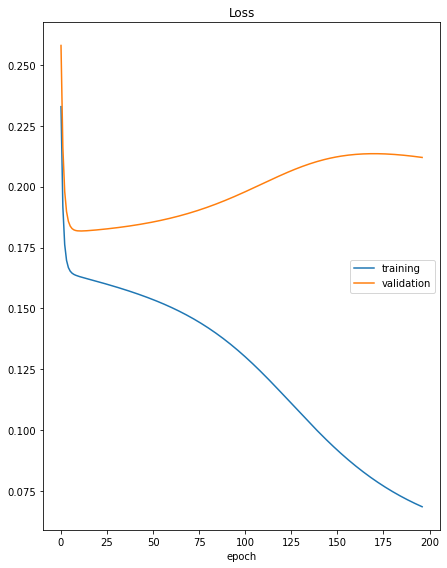

Loss
	training         	 (min:    0.068, max:    0.233, cur:    0.068)
	validation       	 (min:    0.182, max:    0.258, cur:    0.212)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NetflixRecommender,0.048201,0.130007,0.177868,0.254582,0.048201,0.095015,0.114943,0.139666


In [237]:
from recommenders.netflix_recommender import NetflixRecommender

netflix_recommender = NetflixRecommender(embedding_dim=8, n_epochs=200, print_type='live')

netflix_tts_results = [['NetflixRecommender'] + list(evaluate_train_test_split_implicit(
    netflix_recommender, interactions_df, items_df))]

netflix_tts_results = pd.DataFrame(
    netflix_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_tts_results.to_html()))

In [238]:
tts_results = pd.concat([nn_tts_results, amazon_tts_results, netflix_tts_results]).reset_index(drop=True)
display(HTML(tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.000000,0.000339,0.000339,0.001697,0.000000,0.000170,0.000170,0.000574
1,AmazonRecommender,0.046843,0.126273,0.173456,0.248133,0.046843,0.092202,0.111853,0.135876
2,NetflixRecommender,0.048201,0.130007,0.177868,0.254582,0.048201,0.095015,0.114943,0.139666


# Summary

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Write a summary of your experiments. What worked well and what did not? What are your thoughts how could you possibly further improve the model?

In [ ]:
Niestety ten projekt za bardzo dokończyć tak mi się i nie udało. Przyznam się, że nie do końca wiem, dlaczego wyniki moje są tak
złe, bo próbowałem zmieniać liczbę epok, liczbę layers. A wychodziło tylko gorzej, na tyle, że scores wszendzie było 0.0.
W metodzie fit widać, że też próbowałem używać modeli z embeddingami oraz matrix factorization z embeddings, tylko, że ten kod
tak mi się i nie uruchomił(ciągle była gwiazdka w jupyter notebook). Dlatego przedstawiam tu jedyny model, w którym udało mi się
uzyskać chociaż jakiś wynik. I te parametry w NetworkModel dają najlepsze wyniki z moich kombinacji layers oraz liczby neuronów.